In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

# Visualization
import matplotlib.pyplot as plt
from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Sampling
from imblearn.over_sampling import SMOTE

# Utils
from collections import Counter, defaultdict
from itertools import cycle
from scipy import interp

## Data exploartion and preprocessing

In [2]:
dfpos = pd.read_csv('positive_safinal.csv')
dfpos1 = pd.read_csv('positive_safinal2.csv')
dfneg = pd.read_csv('negative_safinal2.csv')
dfneg1 = pd.read_csv('negative_safinal.csv')

In [3]:
dfpos

,review,sentiment
0,greetings and thanks to all bank branch employ...,positive
1,"honestly, the tongue fails to thank the bank w...",positive
2,all respect and appreciation to the gentlemen ...,positive
3,the pinnacle of good morals,positive
4,greetings to all bank branch team,positive
...,...,...
72,Thank you big time.,positive
73,big salute.,positive
74,The big salute.,positive
75,Thank you big salute.,positive


In [4]:
df=pd.concat([dfpos,dfpos1,dfneg, dfneg1], axis=0)

In [5]:
df

,review,sentiment
0,greetings and thanks to all bank branch employ...,positive
1,"honestly, the tongue fails to thank the bank w...",positive
2,all respect and appreciation to the gentlemen ...,positive
3,the pinnacle of good morals,positive
4,greetings to all bank branch team,positive
...,...,...
94,They were disrespectful to the customers.,negative
95,Customers are disrespectful,negative
96,People are disrespectful to the customers.,negative
97,People are disrespectful to other people.,negative


In [6]:
#Ce code permet de mélanger les lignes d'un DataFrame pandas df
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.to_csv('pos_neg_final.csv', index=False)

In [8]:
df

,review,sentiment
0,stb has a wide range of financial products for...,positive
1,For the thousandth time I say it and repeat it...,positive
2,They are the worst bank I have ever dealt with.,negative
3,"stb is transparent and reliable, and I feel sa...",positive
4,I have been a victim of fraud and it was very ...,negative
...,...,...
732,"Who wants to operate his money, put your great...",positive
733,god willing and successful.,positive
734,For the thousandth time I say it and repeat it...,positive
735,The stb has always been there for me when I ne...,positive


In [9]:
#null values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [10]:
#sentiment values
df['sentiment'].value_counts()

sentiment
positive    440
negative    297
Name: count, dtype: int64

In [11]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
    text = re.sub('&gt;', " ", text)
    text = re.sub('&#x27;', "'", text)
    text = re.sub('&#x2F;', ' ', text)
    text = re.sub('<p>', ' ', text)
    text = re.sub('<i>', ' ', text)
    text = re.sub('</i>', ' ', text)
    text = re.sub('&#62;', ' ', text)
    text = re.sub("\n", ' ', text)
    return text

In [12]:
#apply data cleaning function
df['review']=df['review'].apply(lambda x:review_cleaning(x))
df

,review,sentiment
0,stb has a wide range of financial products for...,positive
1,for the thousandth time i say it and repeat it...,positive
2,they are the worst bank i have ever dealt with,negative
3,stb is transparent and reliable and i feel sa...,positive
4,i have been a victim of fraud and it was very ...,negative
...,...,...
732,who wants to operate his money put your great...,positive
733,god willing and successful,positive
734,for the thousandth time i say it and repeat it...,positive
735,the stb has always been there for me when i ne...,positive


In [13]:
#remove punctuations function
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [14]:
#apply punctuations function
df['review']=df['review'].apply(lambda x:remove_punct(x))
df.head()

,review,sentiment
0,stb has a wide range of financial products for...,positive
1,for the thousandth time i say it and repeat it...,positive
2,they are the worst bank i have ever dealt with,negative
3,stb is transparent and reliable and i feel saf...,positive
4,i have been a victim of fraud and it was very ...,negative


In [15]:
#define stop word list
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were',  
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [16]:
#remove stop words
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,review,sentiment
0,stb wide range financial products customers,positive
1,thousandth time say repeat themoknine branch,positive
2,worst bank ever dealt,negative
3,stb transparent reliable feel safe money hands,positive
4,victim fraud difficult get money,negative


In [17]:
#Filtering data
# filtrer les données en fonction du sentiment positif ou négatif
review_pos = df[df["sentiment"]=='positive'].dropna()
# review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = df[df["sentiment"]=='negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])

fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
# freq_dict = defaultdict(int)
# for sent in review_neu["reviews"]:
#     for word in generate_ngrams(sent):
#         freq_dict[word] += 1
# fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
# fd_sorted.columns = ["word", "wordcount"]
# trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

c:\users\ali\anaconda3\lib\site-packages\plotly\tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

c:\users\ali\anaconda3\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.6 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



In [18]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

c:\users\ali\anaconda3\lib\site-packages\plotly\tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

c:\users\ali\anaconda3\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.6 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



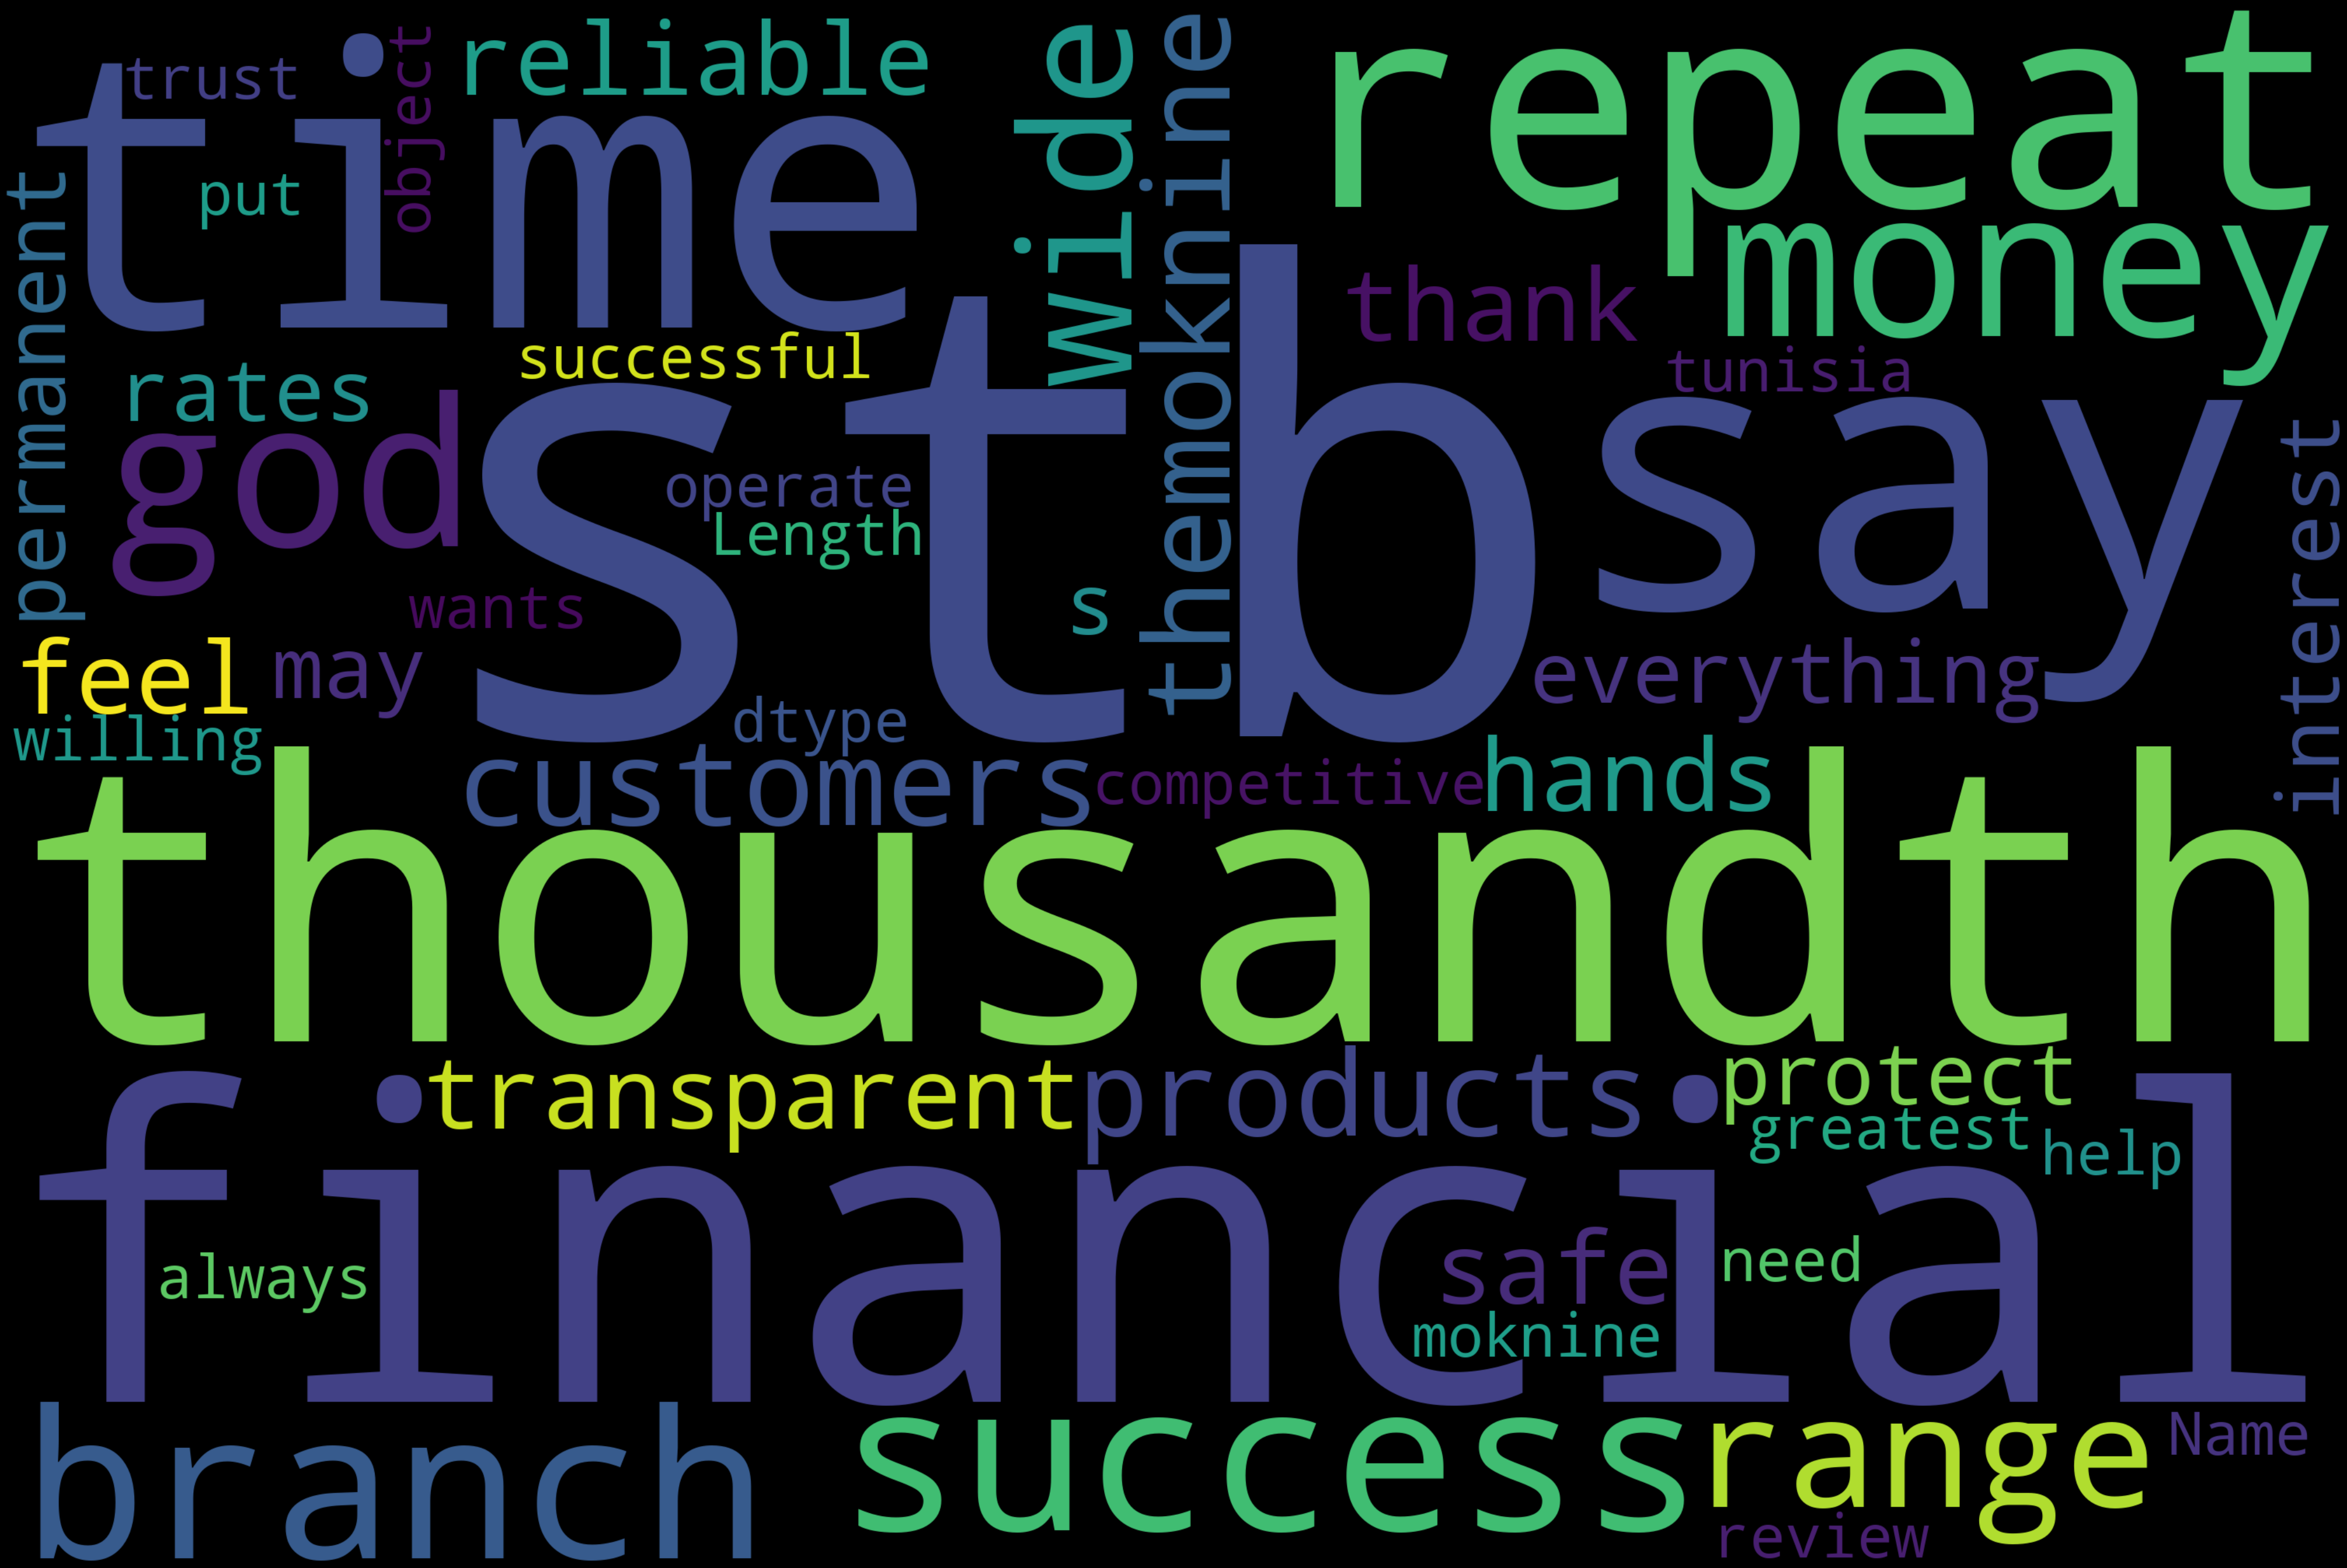

In [19]:
#Frequent positive words
text = review_pos["review"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

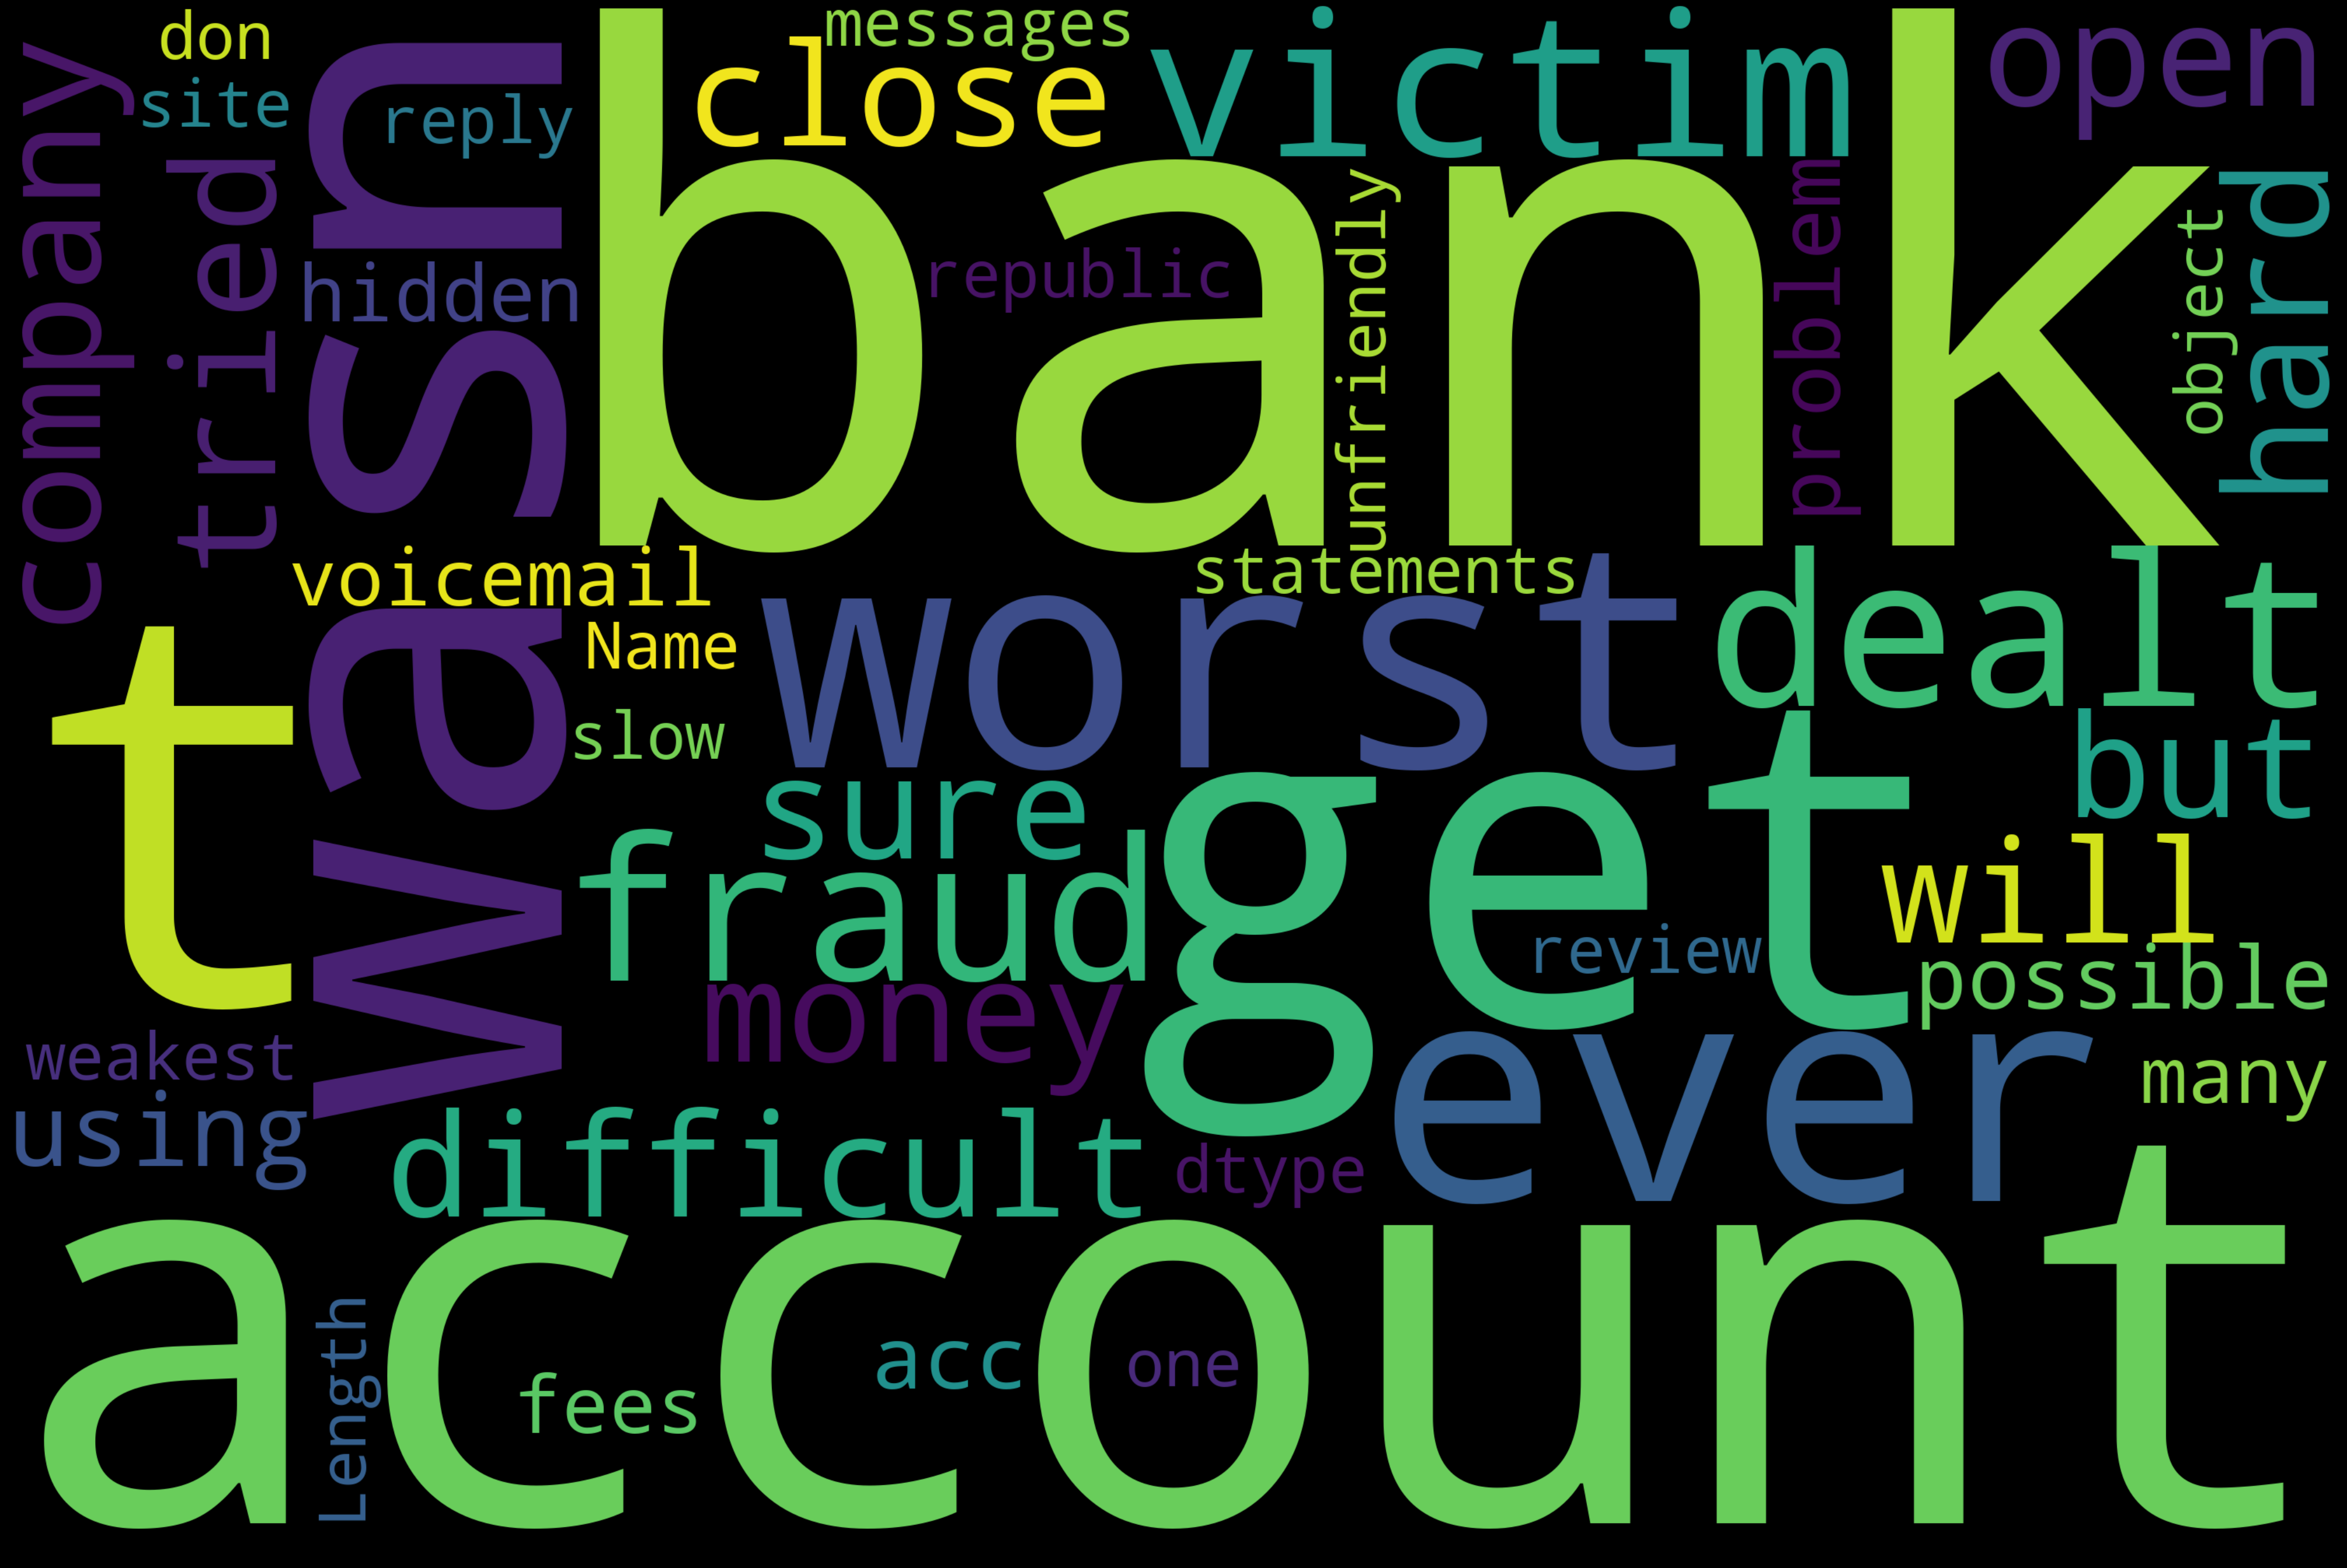

In [20]:
#Frequent negative words
text = review_neg["review"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [21]:
#appel de la fonction encodeur d'étiquettes (1 pour le sentiment positif, 0 pour le sentiment négatif)
label_encoder = preprocessing.LabelEncoder() 

#Encoder les étiquettes dans la colonne 'sentiment'.
df['sentiment']= label_encoder.fit_transform(df['sentiment']) 
  
df['sentiment'].unique() 

array([1, 0])

In [22]:
#Les valeurs de sentiment après encodage
df['sentiment'].value_counts()

sentiment
1    440
0    297
Name: count, dtype: int64

In [23]:
#Example : likely : like  likes : like
from nltk import WordNetLemmatizer
review_features=df.copy()
review_features=df[['review']].reset_index(drop=True)
review_features.head()

,review
0,stb wide range financial products customers
1,thousandth time say repeat themoknine branch
2,worst bank ever dealt
3,stb transparent reliable feel safe money hands
4,victim fraud difficult get money


In [24]:
#create a corpus with cleaned data after preprcessing
ps =WordNetLemmatizer()
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['review'][i])
    review = review.split() 
    review = [ps.lemmatize(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [25]:
corpus

['stb wide range financial product customer',
 'thousandth time say repeat themoknine branch',
 'worst bank ever dealt',
 'stb transparent reliable feel safe money hand',
 'victim fraud difficult get money',
 'will close account',
 'tried open account company but hard',
 'wasn t sure using bank wasn t possible get accurate information service',
 'thank everything',
 'problem bill expense slow processing transaction stb',
 'god may protect success permanent success',
 'salutation work good continuation',
 'good initiative high sense national duty give thousand health thanks',
 'efficiency ethic facilitation condition customer branch tunisian bank company',
 'efficiency ethic facilitation condition customer branch tunisian bank company kairouan',
 'excellent treatment wonderful bank',
 'head branch top employee',
 'tried cancel transfer but difficult give',
 'thank god willing',
 'despicable bank state',
 'tried cancel transfer but process difficult give',
 'god may reward good',
 'accou

## Data modeling

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=350,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(corpus)

In [27]:
#Vocabulary of tfidf with ngram 2
(tfidf_vectorizer.vocabulary_)

{'stb wide': 273,
 'wide range': 333,
 'range financial': 223,
 'financial product': 111,
 'thousandth time': 293,
 'time say': 294,
 'say repeat': 243,
 'worst bank': 345,
 'bank ever': 32,
 'stb transparent': 271,
 'transparent reliable': 298,
 'reliable feel': 230,
 'feel safe': 109,
 'money hand': 182,
 'victim fraud': 325,
 'fraud difficult': 114,
 'will close': 336,
 'close account': 66,
 'tried open': 304,
 'open account': 203,
 'account company': 6,
 'company but': 67,
 'wasn sure': 328,
 'sure using': 280,
 'using bank': 323,
 'bank wasn': 40,
 'wasn possible': 327,
 'possible get': 207,
 'get accurate': 119,
 'accurate information': 11,
 'information service': 159,
 'problem bill': 209,
 'bill expense': 46,
 'expense slow': 105,
 'slow processing': 259,
 'processing transaction': 212,
 'transaction stb': 296,
 'god may': 126,
 'may protect': 178,
 'protect success': 216,
 'success permanent': 277,
 'permanent success': 205,
 'salutation work': 241,
 'work good': 344,
 'good c

In [28]:
#Y is the value that were going to predict 
y=df['sentiment']

In [29]:
#We used smote to make positive and sentiment values equal when training the model
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({1: 440, 0: 297})
Resampled dataset shape Counter({1: 440, 0: 440})


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=0)

In [31]:
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,nb_cv]

best_accuracy = 0
best_model = None
best_model_name = ""

for i, model in enumerate(cv_models):
    accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()
    print(f"{cv_dict[i]} Test Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = cv_dict[i]

print(f"\nBest model: {best_model_name} with accuracy {best_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.9701
Decision Tree Test Accuracy: 0.9565
Naive Bayes Test Accuracy: 0.9701

Best model: Naive Bayes with accuracy 0.9701


In [32]:
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
print(f"Accuracy of the best model ({best_model_name}) on test set: {best_model.score(X_test, y_test):.4f}")

# Calcul des autres métriques pour le meilleur modèle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy of the best model (Naive Bayes) on test set: 0.9432
Accuracy: 94.32%
Precision: 100.00%
Recall: 88.72%
F1 score: 94.02%


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


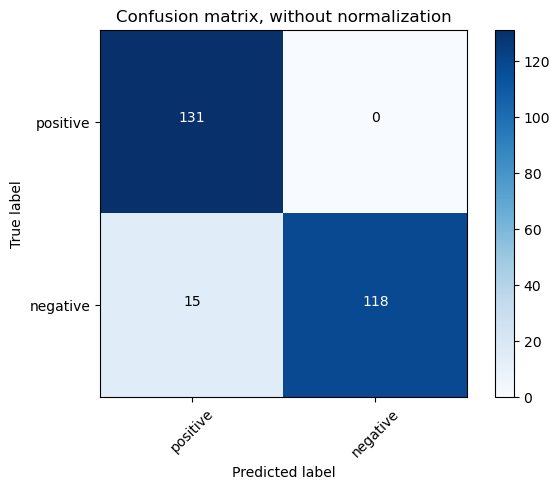

In [35]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred_best)
np.set_printoptions(precision=2)
class_names =['positive','negative']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [36]:
#Download our vectorizer
import pickle
pickle.dump(tfidf_vectorizer, open( "banksatfidf_vectorizer2.pkl", "wb" ) )

In [37]:
#Download our model
import joblib
joblib.dump(logreg,"Bankmodel_Sentiment_Analysis_classification.sav")

['Bankmodel_Sentiment_Analysis_classification.sav']